# QuPath for Python Programmers 🐍
## Graph clustering detections
**Alan O'Callaghan, Léo Leplat, Peter Bankhead, Fiona Inglis, Laura Nicolás Sáenz**

## Creating a gateway

First create a gateway as before:

In [6]:
from qubalab.qupath import qupath_gateway
from qubalab.images.qupath_server import QuPathServer

gateway = qupath_gateway.create_gateway(auth_token=None, port=25333)
qupath_server = QuPathServer(gateway) # read pixels from qupath via gateway

In [7]:
gateway.clearDetections()

## Starting state

Here, we're using a [CC0 fluorescence image](https://ftp.ebi.ac.uk/biostudies/fire/S-BIAD/463/S-BIAD463/Files/my_submission/Validation_raw/DCIS/Patient_test_2.ome.tiff) with cells detected using **InstanSeg**.

This is only a 5-channel image, but this type of approach may be very useful
for highly multiplexed images.

QuPath snapshot:

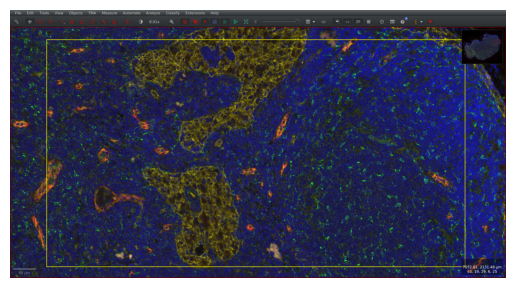

In [10]:
import matplotlib.pyplot as plt

plt.imshow(qupath_gateway.create_snapshot())
plt.axis(False)
plt.show()

## Fetch InstanSeg model

In [11]:
from instanseg import InstanSeg
instanseg = InstanSeg("fluorescence_nuclei_and_cells", image_reader= "tiffslide", verbosity=1)

Model fluorescence_nuclei_and_cells downloaded and extracted to /home/alan/Documents/github/imaging/i2k-python/.venv/lib/python3.10/site-packages/instanseg/utils/../bioimageio_models/
Requesting default device: cuda


<Axes: >

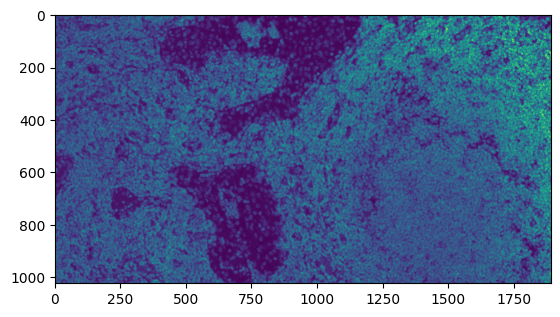

In [12]:
roi = gateway.getSelectedObject().getROI()
x = roi.getBoundsX()
y = roi.getBoundsY()
width = roi.getBoundsWidth()
height = roi.getBoundsHeight()
tile = qupath_server.read_region(downsample=1, x=x, y=y, width=width, height=height)

from qubalab.display.plot import plotImage
_, ax = plt.subplots()
plotImage(ax, tile)

## Running InstanSeg

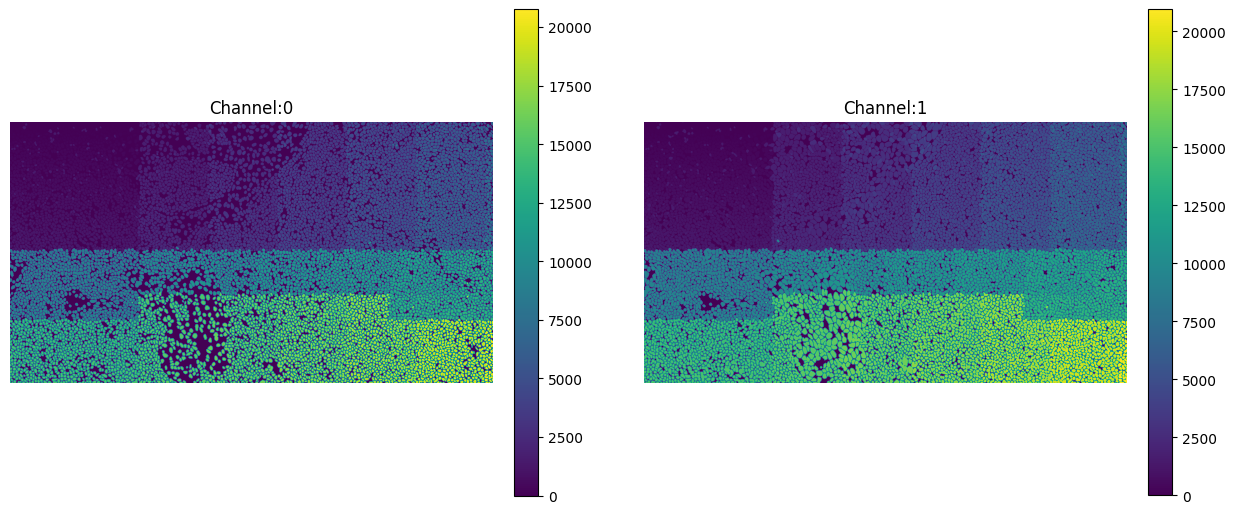

In [14]:
labeled_output = instanseg.eval_medium_image(image = tile, return_image_tensor=False)

from instanseg.utils.utils import show_images
show_images(labeled_output)

## Moving from InstanSeg to QuPath

In [15]:
from instanseg.utils.utils import labels_to_features
# channel 1 is cells, 0 is nuclei
instanseg_objects = labels_to_features(labeled_output[:,1,:].numpy())

import numpy as np
def correct_coords(obj):
    obj["geometry"]["coordinates"] = [[tuple(np.add(coord, (x, y))) for coord in coord_set] for coord_set in obj["geometry"]["coordinates"]]
    obj["properties"]["object_type"] = "detection"
    return obj

instanseg_objects = [correct_coords(obj) for obj in instanseg_objects]
qupath_gateway.add_objects(instanseg_objects)

## InstanSeg output in QuPath

In [ ]:
import matplotlib.pyplot as plt
qupath_gateway.refresh_qupath()

plt.imshow(qupath_gateway.create_snapshot())
plt.axis(False)
plt.show()

## Detections
We can get a list of all detections in the current image,
and make "intensity measurements" on them.

In [ ]:
detections = gateway.getDetectionObjects()
builder = gateway.jvm.qupath.ext.instanseg.core.DetectionMeasurer.builder()
measurer = builder.downsample(1.0).build()
measurer.makeMeasurements(
    gateway.getCurrentImageData(),
    gateway.getDetectionObjects())

Now, let's get a list of the measurements we made.

In [ ]:
names = detections[0].getMeasurementList().getNames()

# filter measurements for simplicity - you could also add measurements here!
# we're just using mean intensity measurements per channel
names = [x for x in names if x.endswith("Mean")]

## Measurement collection

We can make a pandas DataFrame of the detection measurements.

You could also use this to assess feature importance, perform feature
engineering...

In [ ]:
import pandas as pd

df = pd.DataFrame(columns = names)
for det in detections:
    df = df._append(
        {name: det.getMeasurements().get(name) for name in names},
        ignore_index=True)

# standardise the columns to avoid scale and shift effects
normalized_df = (df - df.mean()) / df.std()

## Running UMAP

In [ ]:
import umap

# run a dimensionality reduction algorithm on the measurements
embedding = umap.UMAP().fit_transform(normalized_df)

# assign back to measurement list
for i in range(embedding.shape[0]):
    detections[i].getMeasurementList().put("UMAP1", float(embedding[i][0]))
    detections[i].getMeasurementList().put("UMAP2", float(embedding[i][1]))

We could then create interactive plots in QuPath using these measurements.

## Preparing to cluster cells

In [ ]:
from sklearn.neighbors import kneighbors_graph
import igraph

# find KNN graph
A = kneighbors_graph(normalized_df, 50)

# convert matrix to adjacency matrix
g = igraph.Graph.Adjacency((A > 0))

For large datasets you would use an approximate method, and a suitable K value.

## Running clustering

In [ ]:
import leidenalg

# partition the KNN graph based on graph modularity
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

# assign the partitions as classes to the original QuPath objects
for i in range(embedding.shape[0]):
    detections[i].setClassification(f"Cluster {partition.membership[i]}")

## Clustered cells in QuPath

If we refresh QuPath and show its state, we can see that our clustering looks...
somewhat successful?

Validating the results is another (much more difficult) story that would
require careful annotation and assessment of cluster stability.

In [ ]:
qupath_gateway.refresh_qupath()
plt.imshow(qupath_gateway.create_snapshot())
plt.axis(False)
plt.show()